# **Advancing Pneumonia Diagnosis Through Deep Neural Networks**

### *Group Members:* 
### Adit Patel
### Maisuria Hardik Dharmeshkumar
### Aayush Kansara

# Importing Required Libraries

In [1]:
from IPython.core.interactiveshell import InteractiveShell
import seaborn as sns
# PyTorch
import torchvision
from torchvision import transforms, datasets, models
import torch
from torch import optim, cuda
from torch.utils.data import DataLoader, sampler
import torch.nn as nn

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Data science tools
import numpy as np
import pandas as pd
import os

# Image manipulations
from PIL import Image
# Useful for examining network
# from torchsummary import summary
# Timing utility
from timeit import default_timer as timer

# Visualizations
import matplotlib.pyplot as plt

InteractiveShell.ast_node_interactivity = 'all'

import os
print(os.listdir("../input"))


['chest-xray-pneumonia']


In [2]:
datadir = '../input/chest-xray-pneumonia/chest_xray/'
traindir = os.path.join(datadir,"train/")
validdir = os.path.join(datadir,"val/")
testdir = os.path.join(datadir,"test/")


# Change to fit hardware
batch_size = 128

# Whether to train on a gpu
train_on_gpu = torch.cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')

# Number of gpus
if train_on_gpu:
    gpu_count = torch.cuda.device_count()
    print(f'{gpu_count} gpus detected.')
    if gpu_count > 1:
        multi_gpu = True
    else:
        multi_gpu = False


Train on gpu: True
2 gpus detected.


<Axes: xlabel='category'>

(array([0, 1]), [Text(0, 0, 'NORMAL'), Text(1, 0, 'PNEUMONIA')])

Text(0, 0.5, 'Count')

Text(0.5, 1.0, 'Training Images by Category')

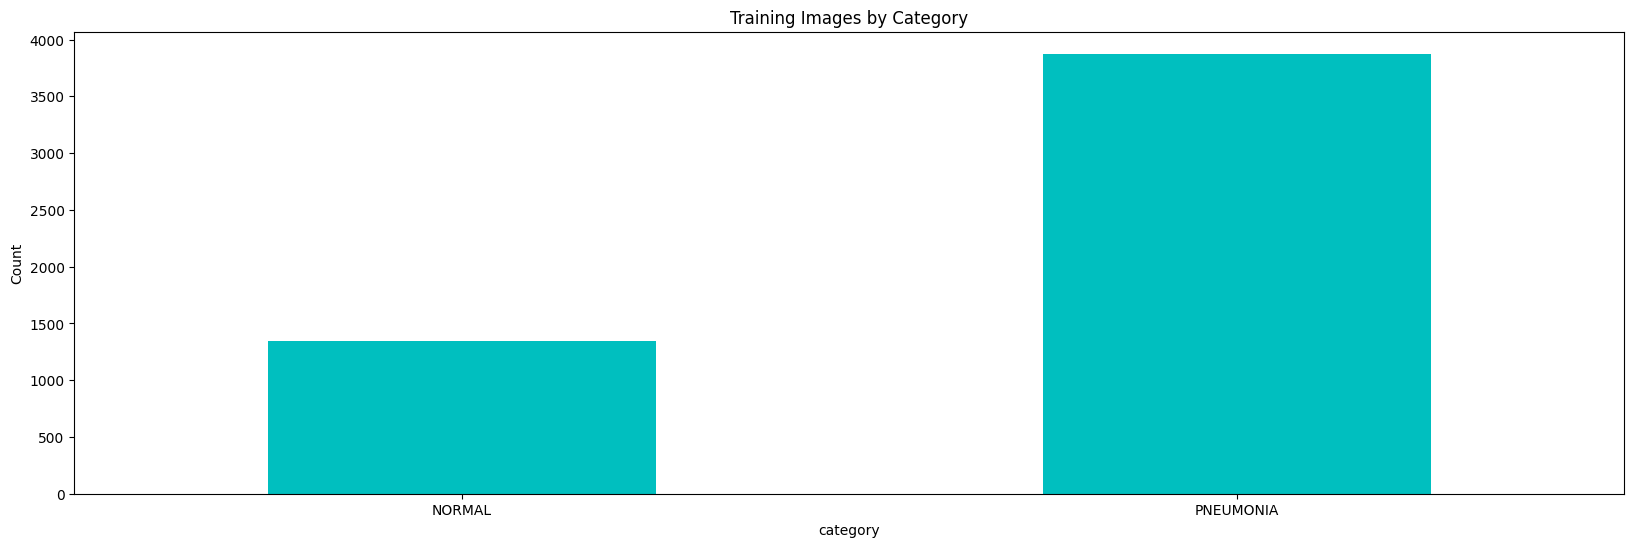

In [3]:
# Empty lists
categories = []
img_categories = []
n_train = []
n_valid = []
n_test = []
hs = []
ws = []

# Iterate through each category
for d in os.listdir(traindir):
    if not d.startswith('.'):
        categories.append(d)

        # Number of each image
        train_imgs = os.listdir(traindir + d)
        valid_imgs = os.listdir(validdir + d)
        test_imgs = os.listdir(testdir + d)
        n_train.append(len(train_imgs))
        n_valid.append(len(valid_imgs))
        n_test.append(len(test_imgs))

        # Find stats for train images
        for i in train_imgs:
            if not i.startswith('.'):
                img_categories.append(d)
                img = Image.open(traindir + d + '/' + i)
                img_array = np.array(img)
                # Shape
                hs.append(img_array.shape[0])
                ws.append(img_array.shape[1])

# Dataframe of categories
cat_df = pd.DataFrame({'category': categories,
                       'n_train': n_train,
                       'n_valid': n_valid, 'n_test': n_test}).\
    sort_values('category')

# Dataframe of training images
image_df = pd.DataFrame({
    'category': img_categories,
    'height': hs,
    'width': ws
})

#cat_df.sort_values('n_train', ascending=False, inplace=True)
cat_df.set_index('category')['n_train'].plot.bar(
    color='c', figsize=(20, 6))
plt.xticks(rotation=0)
plt.ylabel('Count')
plt.title('Training Images by Category')


In [7]:
def imshow(image, cmap='gray'):
    """Display image"""
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.show()


(1013, 1528)

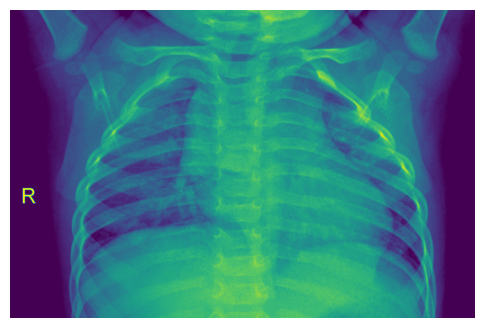

In [8]:
x = Image.open(traindir + 'NORMAL/IM-0128-0001.jpeg')
np.array(x).shape
imshow(x)


(863, 1244)

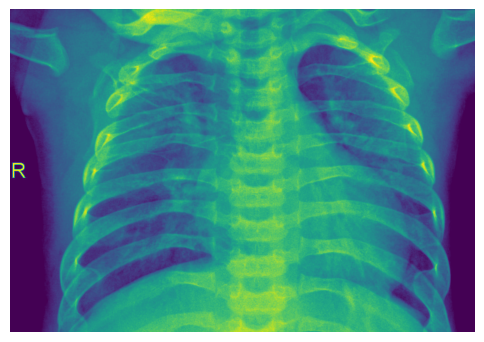

In [9]:
x = Image.open(traindir + 'PNEUMONIA/person1001_bacteria_2932.jpeg')
np.array(x).shape
imshow(x)


# Data Preprocessing and Augmentation

##### 1. Data Preprocessing:
##### To prepare the images for our neural network, we need to resize them to a standard size of 224 x 224 pixels and perform normalization on each color channel. This normalization involves subtracting a mean value and dividing by a standard deviation. Additionally, we'll apply data augmentation techniques to enhance our training dataset. These transformations are carried out using image transforms, which help in preprocessing our data effectively for neural network training.

##### 2. Data Augmentation:

##### To get more data, we just need to make minor alterations to our existing dataset. Minor changes such as flips or translations or rotations. Our neural network would think these are distinct images anyway. A convolutional neural network that can robustly classify objects even if its placed in different orientations is said to have the property called invariance. More specifically, a CNN can be invariant to translation, viewpoint, size or illumination (Or a combination of the above). This means for training, we randomly resize and crop the images and also flip them horizontally. A different random transformation is applied each epoch (while training), so the network effectively sees many different versions of the same image. All of the data is also converted to Torch Tensors before normalization. The validation and testing data is not augmented but is only resized and normalized. The normalization values are standardized for Imagenet.





In [10]:
image_transforms = dict()

image_transforms['train'] = transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=10),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),  
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225]) 
    ])


image_transforms['val']= transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

image_transforms['test'] = image_transforms['val']

In [11]:
data = {
    'train':
    datasets.ImageFolder(root=traindir, transform=image_transforms['train']),
    'val':
    datasets.ImageFolder(root=validdir, transform=image_transforms['val']),
    'test':
    datasets.ImageFolder(root=testdir, transform=image_transforms['test'])
}

# Dataloader iterators
dataloaders = {
    'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True),
    'val': DataLoader(data['val'], batch_size=batch_size, shuffle=True),
    'test': DataLoader(data['test'], batch_size=batch_size, shuffle=True)
}

In [12]:
trainiter = iter(dataloaders['train'])
features, labels = next(trainiter)
features.shape, labels.shape


(torch.Size([128, 3, 224, 224]), torch.Size([128]))

In [13]:
n_classes = len(cat_df)
print(f'There are {n_classes} different classes.')

len(data['train'].classes)


There are 2 different classes.


2

In [14]:
data['train'].classes

['NORMAL', 'PNEUMONIA']

# Data Augmentation with GAN

In [26]:
from torch.utils.data import Dataset
class FolderDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.file_list = os.listdir(root_dir)

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.file_list[idx])
#         image = Image.open(img_name)
        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

In [30]:
dataset_class_0 = FolderDataset(root_dir=os.path.join(traindir,"NORMAL"),    transform=image_transforms['val'])
dataset_class_1 = FolderDataset(root_dir=os.path.join(traindir,"PNEUMONIA"),    transform=image_transforms['val'])

dataloader_class_0 = DataLoader(dataset_class_0, batch_size=128, shuffle=True, num_workers=4)
dataloader_class_1 = DataLoader(dataset_class_1, batch_size=128, shuffle=True, num_workers=4)

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.utils import save_image
import os
from tqdm import tqdm
class Generator(nn.Module):
    def __init__(self, noise_dim, channels=3):
        super(Generator, self).__init__()
        self.noise_dim = noise_dim
        self.channels = channels

        self.main = nn.Sequential(
            # Input: (noise_dim)
            nn.ConvTranspose2d(noise_dim, 1024, 4, 1, 0, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(True),

            # (1024, 4, 4)
            nn.ConvTranspose2d(1024, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            # (512, 8, 8)
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            # (256, 16, 16)
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            # (128, 32, 32)
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            # (64, 64, 64)
            nn.ConvTranspose2d(64, channels, 4, 2, 1, bias=False),
            nn.Tanh(),
            # Output: (channels, 256, 256)
            
            nn.ConvTranspose2d(channels, channels, 4, 2, 1, bias=False),
#             nn.Tanh()
        )

    def forward(self, noise):
        noise = noise.view(noise.size(0), self.noise_dim, 1, 1)
        return self.main(noise)

class Discriminator(nn.Module):
    def __init__(self, channels):
        super(Discriminator, self).__init__()
        self.channels = channels

        self.main = nn.Sequential(
            # Input: (channels, 256, 256)
            nn.Conv2d(channels, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            # (64, 128, 128)
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            # (128, 64, 64)
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            # (256, 32, 32)
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            # (512, 16, 16)
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
            # Output: (1, 1, 1)
        )

    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)

In [35]:
def train_gan(generator, discriminator, dataloader, num_epochs=1, batch_size=128, device='cuda'):
    criterion = nn.BCELoss()
    optimizer_g = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    generator.to(device)
    discriminator.to(device)

    for epoch in range(num_epochs):
        for i, real_images in enumerate(tqdm(dataloader)):
            real_images = real_images.to(device)
            batch_size = real_images.size(0)

            # Train discriminator
            optimizer_d.zero_grad()

            # Real images
            real_preds = discriminator(real_images)
            real_loss = criterion(real_preds, torch.ones_like(real_preds))
            real_loss.backward()

            # Fake images
            z = torch.randn(batch_size, 128).to(device)
            fake_images = generator(z)
            fake_preds = discriminator(fake_images.detach())
            fake_loss = criterion(fake_preds, torch.zeros_like(fake_preds))
            fake_loss.backward()

            optimizer_d.step()

            # Train generator
            optimizer_g.zero_grad()
            z = torch.randn(batch_size, 128).to(device)
            fake_images = generator(z)
            preds = discriminator(fake_images)
            loss_g = criterion(preds, torch.ones_like(preds))
            loss_g.backward()
            optimizer_g.step()

            if i % 100 == 0:
                print(f"Epoch [{epoch}/{num_epochs}], Batch Step [{i}/{len(dataloader)}], "
                      f"Discriminator Loss: {real_loss.item() + fake_loss.item()}, Generator Loss: {loss_g.item()}")

# Example usage

generator_class_0 = Generator(128)
discriminator_class_0 = Discriminator(3)
generator_class_1 = Generator(128)
discriminator_class_1 = Discriminator(3)

train_gan(generator_class_0, discriminator_class_0, dataloader_class_0,10)
train_gan(generator_class_1, discriminator_class_1, dataloader_class_1,10)


  9%|▉         | 1/11 [00:08<01:28,  8.86s/it]

Epoch [0/10], Batch Step [0/11], Discriminator Loss: 1.441071331501007, Generator Loss: 1.3001543283462524


  9%|▉         | 1/11 [00:08<01:27,  8.76s/it]

Epoch [1/10], Batch Step [0/11], Discriminator Loss: 0.8305627703666687, Generator Loss: 2.0564868450164795


  9%|▉         | 1/11 [00:08<01:24,  8.45s/it]

Epoch [2/10], Batch Step [0/11], Discriminator Loss: 0.2536659389734268, Generator Loss: 3.551766872406006


  9%|▉         | 1/11 [00:08<01:24,  8.41s/it]

Epoch [3/10], Batch Step [0/11], Discriminator Loss: 0.1615200899541378, Generator Loss: 4.3210673332214355


  9%|▉         | 1/11 [00:08<01:24,  8.43s/it]

Epoch [4/10], Batch Step [0/11], Discriminator Loss: 0.07787001505494118, Generator Loss: 4.835816860198975


  9%|▉         | 1/11 [00:09<01:37,  9.73s/it]

Epoch [5/10], Batch Step [0/11], Discriminator Loss: 0.04790358804166317, Generator Loss: 5.010648250579834


  9%|▉         | 1/11 [00:08<01:22,  8.26s/it]

Epoch [6/10], Batch Step [0/11], Discriminator Loss: 0.03758977726101875, Generator Loss: 5.092574596405029


  9%|▉         | 1/11 [00:08<01:28,  8.85s/it]

Epoch [7/10], Batch Step [0/11], Discriminator Loss: 0.026755595579743385, Generator Loss: 5.121699333190918


  9%|▉         | 1/11 [00:09<01:34,  9.50s/it]

Epoch [8/10], Batch Step [0/11], Discriminator Loss: 0.02120367344468832, Generator Loss: 5.3457441329956055


  9%|▉         | 1/11 [00:08<01:22,  8.27s/it]

Epoch [9/10], Batch Step [0/11], Discriminator Loss: 0.014673191122710705, Generator Loss: 5.533545017242432


  3%|▎         | 1/31 [00:05<02:46,  5.54s/it]

Epoch [0/10], Batch Step [0/31], Discriminator Loss: 1.400229573249817, Generator Loss: 1.2471015453338623


  3%|▎         | 1/31 [00:04<02:26,  4.88s/it]

Epoch [1/10], Batch Step [0/31], Discriminator Loss: 0.4595523029565811, Generator Loss: 3.3059496879577637


  3%|▎         | 1/31 [00:04<02:29,  4.98s/it]

Epoch [2/10], Batch Step [0/31], Discriminator Loss: 0.04852377250790596, Generator Loss: 4.8362956047058105


  3%|▎         | 1/31 [00:04<02:19,  4.66s/it]

Epoch [3/10], Batch Step [0/31], Discriminator Loss: 0.019371818751096725, Generator Loss: 5.18789529800415


  3%|▎         | 1/31 [00:04<02:23,  4.80s/it]

Epoch [4/10], Batch Step [0/31], Discriminator Loss: 0.01252836175262928, Generator Loss: 5.472218036651611


  3%|▎         | 1/31 [00:04<02:29,  4.99s/it]

Epoch [5/10], Batch Step [0/31], Discriminator Loss: 0.008763596881181002, Generator Loss: 5.75507926940918


  3%|▎         | 1/31 [00:04<02:23,  4.77s/it]

Epoch [6/10], Batch Step [0/31], Discriminator Loss: 0.00675553223118186, Generator Loss: 6.06189489364624


  3%|▎         | 1/31 [00:04<02:20,  4.70s/it]

Epoch [7/10], Batch Step [0/31], Discriminator Loss: 0.005676994798704982, Generator Loss: 6.265323162078857


  3%|▎         | 1/31 [00:04<02:27,  4.93s/it]

Epoch [8/10], Batch Step [0/31], Discriminator Loss: 0.006769801955670118, Generator Loss: 6.39007043838501


  3%|▎         | 1/31 [00:04<02:24,  4.82s/it]

Epoch [9/10], Batch Step [0/31], Discriminator Loss: 0.9274256229400635, Generator Loss: 1.2614171504974365


100%|██████████| 31/31 [00:53<00:00,  1.72s/it]


In [36]:
import os
import random
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image


def generate_fake_image(generator):
    
    a = torch.randn(1, 128).to('cuda')
    return generator(a)

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None, fake_generator_0=None, fake_generator_1=None):
        self.root_dir = root_dir
        self.transform = transform
        self.fake_generator_0 = fake_generator_0
        self.fake_generator_1 = fake_generator_1

        self.classes = ['NORMAL', 'PNEUMONIA']
        self.class_0_files = os.listdir(os.path.join(self.root_dir, 'NORMAL'))
        self.class_1_files = os.listdir(os.path.join(self.root_dir, 'PNEUMONIA'))

    def __len__(self):
        # Assuming both classes have equal number of images
        return min(len(self.class_0_files), len(self.class_1_files))

    def __getitem__(self, idx):
        class_choice = random.randint(0, 1)  # Randomly choose class

        if class_choice == 0:
            image_path = os.path.join(self.root_dir, 'NORMAL', self.class_0_files[idx])
            label = 0
        else:
            image_path = os.path.join(self.root_dir, 'PNEUMONIA', self.class_1_files[idx])
            label = 1

        if random.choice([True, False]):  # Randomly choose between real and fake
            image = Image.open(image_path).convert('RGB')
        else:
            if class_choice == 0:
                fake_image = generate_fake_image(self.fake_generator_0).detach().cpu().numpy()
            else:
                fake_image = generate_fake_image(self.fake_generator_1).detach().cpu().numpy()
            fake_image = fake_image.reshape((256,256,3)).astype(np.uint8)
            image = Image.fromarray(fake_image)

        if self.transform:
            image = self.transform(image)

        return image, label


In [37]:
train_dataset = CustomDataset(traindir,image_transforms['val'],generator_class_0,generator_class_1)

In [38]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [39]:
trainiter = iter(train_loader)
features, labels = next(trainiter)
features.shape, labels.shape


(torch.Size([128, 3, 224, 224]), torch.Size([128]))

In [40]:
dataloaders['train'] = train_loader

# Building Models

### Defining base model

In [41]:
base_model_resnet = models.resnext50_32x4d(pretrained=True)
base_model_densenet = models.densenet121(pretrained=True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth
100%|██████████| 95.8M/95.8M [00:00<00:00, 148MB/s] 
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated si

### Freezing the weights of base model

In [42]:
for param in base_model_resnet.parameters():
    param.requires_grad = False

for param in base_model_densenet.parameters():
    param.requires_grad = False

### Deifining the final model

In [43]:
class FinalModel(nn.Module):
    
    def __init__(self,base_model):
        
        super().__init__()
        
        self.base_model = base_model
        self.fc = nn.Linear(1000,64)
        self.classification_layer = nn.Linear(64,2)
        self.activation_layer = nn.LogSoftmax(dim=1)
    
    def forward(self,x):
        
        x = self.base_model(x)
        x = self.fc(x)
        x = self.classification_layer(x)
        x = self.activation_layer(x)
        return x

In [44]:
resnet_model = FinalModel(base_model_resnet)
densenet_model = FinalModel(base_model_densenet)

In [45]:
print("1. Resnet Model")
total_params = sum(p.numel() for p in resnet_model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in resnet_model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')
print()
print("2. Densenet Model")
total_params = sum(p.numel() for p in densenet_model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in densenet_model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

1. Resnet Model
25,093,098 total parameters.
64,194 training parameters.

2. Densenet Model
8,043,050 total parameters.
64,194 training parameters.


In [46]:
if train_on_gpu:
    resnet_model = resnet_model.to('cuda')

if train_on_gpu:
    densenet_model = densenet_model.to('cuda')


# Training the models

In [47]:
criterion_resnet = nn.NLLLoss()
optimizer_resnet = optim.Adam(resnet_model.parameters())

criterion_densenet = nn.NLLLoss()
optimizer_densenet = optim.Adam(densenet_model.parameters())

In [48]:
from tqdm import tqdm

def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=10, patience=5):
    best_val_loss = float('inf')
    counter = 0
    best_model_state = None
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = dataloaders['train']
            else:
                model.eval()
                dataloader = dataloaders['val']

            running_loss = 0.0
            with tqdm(total=len(dataloader), desc=f'{phase.capitalize()} Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
                for i, (inputs, labels) in enumerate(dataloader, 1):
                    inputs, labels = inputs.to(device), labels.to(device)
                    optimizer.zero_grad()
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    running_loss += loss.item() * inputs.size(0)
                    pbar.set_postfix({'loss': loss.item()})
                    pbar.update()

            epoch_loss = running_loss / len(dataloader.dataset)

            if phase == 'train':
                train_loss = epoch_loss
            else:
                val_loss = epoch_loss
                print(f'{phase.capitalize()} Loss: {val_loss:.4f}')

                # Save best model
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    counter = 0
                    best_model_state = model.state_dict()
                    torch.save(best_model_state, 'best_model.pth')
                else:
                    counter += 1
                    if counter >= patience:
                        print("Early stopping")
                        break
        if counter >= patience:
            break

    # Load the best model state
    model.load_state_dict(best_model_state)
    return model


In [49]:
device = torch.device('cuda')
num_epochs = 10
patience = 3

In [50]:
#resenet training
resnet_model = train_model(
    resnet_model,
    dataloaders,
    criterion_resnet,
    optimizer_resnet,
    device,
    num_epochs,
    patience)

Epoch 1/10


Val Epoch 1/10: 100%|██████████| 1/1 [00:00<00:00,  2.12batch/s, loss=0.354]


Val Loss: 0.3543
Epoch 2/10


Val Epoch 2/10: 100%|██████████| 1/1 [00:00<00:00,  2.95batch/s, loss=0.86]


Val Loss: 0.8595
Epoch 3/10


Val Epoch 3/10: 100%|██████████| 1/1 [00:00<00:00,  2.95batch/s, loss=1.33]


Val Loss: 1.3307
Epoch 4/10


Val Epoch 4/10: 100%|██████████| 1/1 [00:00<00:00,  2.93batch/s, loss=1.15]

Val Loss: 1.1538
Early stopping


In [51]:
#densenet training
densenet_model = train_model(
    densenet_model,
    dataloaders,
    criterion_densenet,
    optimizer_densenet,
    device,
    num_epochs,
    patience)

Epoch 1/10


Val Epoch 1/10: 100%|██████████| 1/1 [00:00<00:00,  2.37batch/s, loss=0.274]


Val Loss: 0.2742
Epoch 2/10


Val Epoch 2/10: 100%|██████████| 1/1 [00:00<00:00,  3.10batch/s, loss=0.692]


Val Loss: 0.6923
Epoch 3/10


Val Epoch 3/10: 100%|██████████| 1/1 [00:00<00:00,  2.76batch/s, loss=0.378]


Val Loss: 0.3783
Epoch 4/10


Val Epoch 4/10: 100%|██████████| 1/1 [00:00<00:00,  3.01batch/s, loss=0.255]


Val Loss: 0.2553
Epoch 5/10


Val Epoch 5/10: 100%|██████████| 1/1 [00:00<00:00,  3.05batch/s, loss=0.441]


Val Loss: 0.4405
Epoch 6/10


Val Epoch 6/10: 100%|██████████| 1/1 [00:00<00:00,  3.07batch/s, loss=0.569]


Val Loss: 0.5693
Epoch 7/10


Val Epoch 7/10: 100%|██████████| 1/1 [00:00<00:00,  3.00batch/s, loss=0.177]


Val Loss: 0.1768
Epoch 8/10


Val Epoch 8/10: 100%|██████████| 1/1 [00:00<00:00,  3.07batch/s, loss=0.374]


Val Loss: 0.3741
Epoch 9/10


Val Epoch 9/10: 100%|██████████| 1/1 [00:00<00:00,  2.90batch/s, loss=0.263]


Val Loss: 0.2629
Epoch 10/10


Val Epoch 10/10: 100%|██████████| 1/1 [00:00<00:00,  2.97batch/s, loss=0.447]

Val Loss: 0.4474
Early stopping


# Model Evaluation

In [55]:
criterion_resnet = nn.NLLLoss()
optimizer_resnet = optim.Adam(resnet_model.parameters())

criterion_densenet = nn.NLLLoss()
optimizer_densenet = optim.Adam(densenet_model.parameters())

In [57]:
from sklearn.metrics import precision_score, f1_score, accuracy_score, recall_score

test_loader=dataloaders['test']
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))
classes = [0,1]
resnet_model.eval()
i=1
true_labels = []
predicted_labels = []

# iterate over test data
len(test_loader)
for data, target in test_loader:
    i=i+1
    if len(target)!=batch_size:
        continue
        
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the resnet_model
    output = resnet_model(data)
    # calculate the batch loss
    loss = criterion_resnet(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    
    true_labels.extend(target.cpu().numpy())
    predicted_labels.extend(pred.cpu().numpy())

    for i in range(batch_size):       
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

# Calculate precision, F1 score, and accuracy
precision_ResNet = precision_score(true_labels, predicted_labels, average='weighted')
recall_ResNet = recall_score(true_labels, predicted_labels, average='weighted')
f1_ResNet = f1_score(true_labels, predicted_labels, average='weighted')
accuracy_ResNet = accuracy_score(true_labels, predicted_labels)

print()
print("====== Resnet Metrics =====")
print('Precision: {:.2f}'.format(precision_ResNet))
print('Recall: {:.2f}'.format(recall_ResNet))
print('F1 Score: {:.2f}'.format(f1_ResNet))
print('Accuracy: {:.2f}'.format(accuracy_ResNet))


FinalModel(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample):

5

Test Loss: 0.797814

Test Accuracy of     0: 28% (56/195)
Test Accuracy of     1: 98% (313/317)

Test Accuracy (Overall): 72% (369/512)

====== Resnet Metrics =====
Precision: 0.78
Recall: 0.72
F1 Score: 0.67
Accuracy: 0.72


In [59]:
from sklearn.metrics import precision_score, f1_score, accuracy_score, recall_score

test_loader=dataloaders['test']
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))
classes = [0,1]
densenet_model.eval()
i=1
true_labels = []
predicted_labels = []

# iterate over test data
len(test_loader)
for data, target in test_loader:
    i=i+1
    if len(target)!=batch_size:
        continue
        
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the densenet_model
    output = densenet_model(data)
    # calculate the batch loss
    loss = criterion_densenet(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    
    true_labels.extend(target.cpu().numpy())
    predicted_labels.extend(pred.cpu().numpy())

    for i in range(batch_size):       
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

# Calculate precision, F1 score, and accuracy
precision_denseNet = precision_score(true_labels, predicted_labels, average='weighted')
recall_denseNet = recall_score(true_labels, predicted_labels, average='weighted')
f1_denseNet = f1_score(true_labels, predicted_labels, average='weighted')
accuracy_denseNet = accuracy_score(true_labels, predicted_labels)

print()
print("====== densenet Metrics =====")
print('Precision: {:.2f}'.format(precision_denseNet))
print('Recall: {:.2f}'.format(recall_denseNet))
print('F1 Score: {:.2f}'.format(f1_denseNet))
print('Accuracy: {:.2f}'.format(accuracy_denseNet))


FinalModel(
  (base_model): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, moment

5

Test Loss: 0.368185

Test Accuracy of     0: 65% (128/194)
Test Accuracy of     1: 97% (310/318)

Test Accuracy (Overall): 85% (438/512)

====== densenet Metrics =====
Precision: 0.87
Recall: 0.86
F1 Score: 0.85
Accuracy: 0.86


In [62]:
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import confusion_matrix

def generate_confusion_matrix(model, test_loader, classes,model_name):
    true_labels = []
    predicted_labels = []

    # Iterate over the test DataLoader
    for inputs, labels in test_loader:
        # Forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(inputs.to(device))
        
        _, preds = torch.max(outputs, 1)   
#         # Get the predicted class labels
#         preds = torch.round(outputs)  # Assuming sigmoid activation for binary classification
        # Append true and predicted labels to the lists
        true_labels.extend(labels.numpy())
        predicted_labels.extend(preds.detach().cpu().numpy())
        

    # Convert lists to numpy arrays
    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)

    print(np.min(predicted_labels),np.max(predicted_labels))

    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(true_labels, predicted_labels)

    # Create a seaborn heatmap of the confusion matrix
    sns.set(font_scale=1.2)  # Increase font size for better readability
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()


0 1


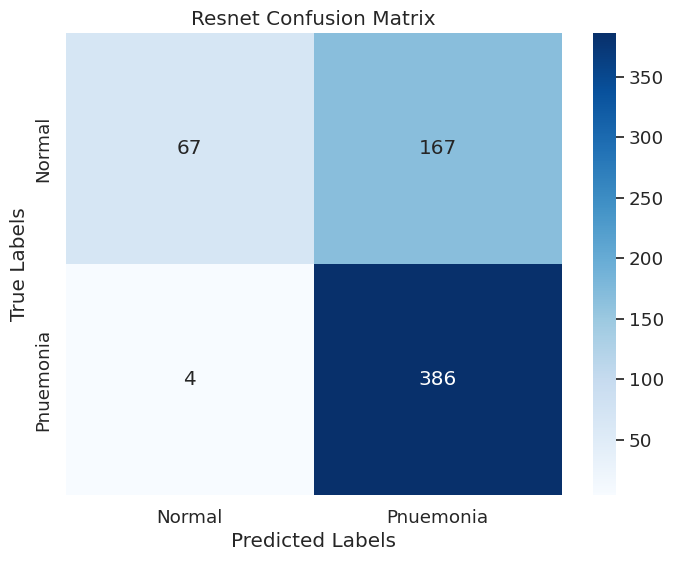

In [63]:
generate_confusion_matrix(resnet_model, dataloaders['test'], ['Normal', 'Pnuemonia'],"Resnet")

0 1


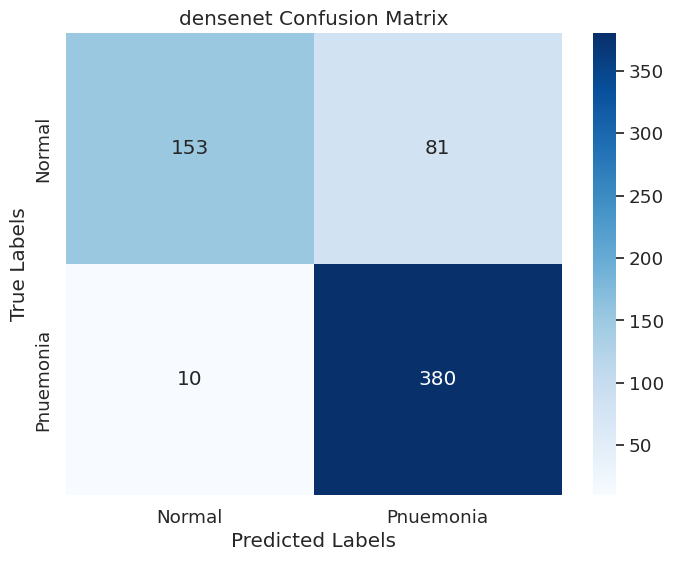

In [64]:
generate_confusion_matrix(densenet_model, dataloaders['test'], ['Normal', 'Pnuemonia'],"densenet")